## **Exploratory Data Analysis of Lending Club data for loans issued between 2007 and 2018**

In [1]:
import operator
import math
import base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from fancyimpute import IterativeImputer
from wordcloud import WordCloud

Using TensorFlow backend.


In [2]:
util = base.utils()

In [3]:
def plot_distribution(dataframe, focus_col, against_col, title_1, title_2):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.distplot(dataframe[focus_col], ax=ax[0])
    ax[0].set_title(title_1, fontsize=14)
    sns.boxplot(x=dataframe[focus_col], y=dataframe[against_col], data=dataframe, ax=ax[1])
    ax[1].set_title(title_2, fontsize=14)

In [4]:
def get_violin_plot(x_axis, y_axis, hue_column, data, order):
    plt.figure(figsize=(15,5))
    if order == None:
        ax = sns.violinplot(x=x_axis, y=y_axis, hue=hue_column, data=data, split=True, inner='box')
    else:
        ax = sns.violinplot(x=x_axis, y=y_axis, hue=hue_column, data=data, split=True, inner='box', order=order)

In [5]:
# Binning of dependent variable into categories: Good, Bad and Current loan
def loan_type(status):
    bad_loan = ['Charged Off', 'Default', 'Late (31-120 days)']
    current_loan = ['Current', 'In Grace Period', 'Late (16-30 days)']
    if status in bad_loan:
        return 'Bad Loan'
    elif status in current_loan:
        return 'Current Loan'
    else:
        return 'Good Loan'

In [6]:
def get_all_missing_value_counts(data):
    missing_value_columns = 0
    for feature in data.columns:
        if data[feature].isna().mean() > 0:
            count = (len(data[data[feature].isna() == True]) / len(data[feature]))*100
            if count > 50.00:
                missing_value_columns = missing_value_columns + 1
                print(feature, ': %2.2f' %count)
    return missing_value_columns

In [7]:
def get_heat_map(data, features, x_size, y_size, title):
    f, ax = plt.subplots(figsize=(x_size, y_size))
    corr = data[features].corr()
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True), annot=True)
    ax.set_title(title)

In [8]:
def get_missing_value_count(data,feature):
    return (data[data[feature].isna() == True].shape[0]/data[feature].shape[0])*100
    #return (len(data[data[feature].isna() == True]) / len(data[feature]))*100

In [9]:
def impute_by_mice(data, feature, data_type):
    if data_type == 'float':
        return IterativeImputer().fit_transform(np.array(data[feature].astype(float)).reshape(-1, 1))

## **Read dataset**

In [10]:
data = pd.read_csv('datasets/LendingClub/AcceptedLoans_2007_to_2018.csv', low_memory=False)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


**Remove summary records from dataset**

In [11]:
indices_to_be_dropped = data[data['id'].str.contains('Total amount funded in policy code')].index
data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

indices_to_be_dropped = data[data['id'].str.contains('Loans that do not meet the credit policy')].index
data.drop(index=indices_to_be_dropped, axis=0, inplace=True)

In [12]:
print('The dataset has ', data.shape[0], ' records and ', data.shape[1], ' variables.')

The dataset has  2260668  records and  151  variables.


In [13]:
#data.describe().transpose()

## **Analysis of Categorical data**

From the dataset, we find the below categorical features:
- grade d
- sub_grade d
- emp_title d
- home_ownership d
- verification_status d
- pymnt_plan d 
- url d
- desc d
- purpose d
- title d
- zip_code d
- addr_state d
- initial_list_status
- application_type d
- verification_status_joint
- hardship_flag
- hardship_type
- hardship_reason
- hardship_status
- disbursement_method
- debt_settlement_flag
- settlement_status

In [14]:
cat_cols = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status', 'application_type', 'verification_status_joint', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'disbursement_method', 'debt_settlement_flag', 'settlement_status']

If a categorical feature has only 1 value, we can assume it has no contribution towards the dependent variable and can be dropped.

In [15]:
for feature in cat_cols:
    print(feature, ': ', data[feature].nunique())

grade :  7
sub_grade :  35
emp_title :  512694
home_ownership :  6
verification_status :  3
pymnt_plan :  2
url :  2260668
desc :  124501
purpose :  14
title :  63155
zip_code :  956
addr_state :  51
initial_list_status :  2
application_type :  2
verification_status_joint :  3
hardship_flag :  2
hardship_type :  1
hardship_reason :  9
hardship_status :  3
disbursement_method :  2
debt_settlement_flag :  2
settlement_status :  3


From the above data, we find that all features have more than 1 unique value. However, some of the features might have missing data and hence contribute to the count of the unique values. Hence, further analysis is needed.

In [16]:
data['pymnt_plan'].value_counts()

n    2260048
y        620
Name: pymnt_plan, dtype: int64

In [17]:
data['initial_list_status'].value_counts()

w    1535467
f     725201
Name: initial_list_status, dtype: int64

In [18]:
data['application_type'].value_counts()

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

In [19]:
data['hardship_flag'].value_counts()

N    2259836
Y        832
Name: hardship_flag, dtype: int64

In [20]:
data['hardship_type'].value_counts()

INTEREST ONLY-3 MONTHS DEFERRAL    10917
Name: hardship_type, dtype: int64

In [21]:
data['disbursement_method'].value_counts()

Cash         2182546
DirectPay      78122
Name: disbursement_method, dtype: int64

In [22]:
data['debt_settlement_flag'].value_counts()

N    2226422
Y      34246
Name: debt_settlement_flag, dtype: int64

From the above analysis, we find that the variable **'hardship_type'** has only one value. But more analysis is needed before finally deciding whether it can be dropped or not.

## **Analysis of Numerical data**

In [23]:
num_cols = list(data.columns)

for item in cat_cols:
    num_cols.remove(item)

If a numerical feature has only 1 value, we can assume it no contribution towards the dependent variable and can be dropped.

In [24]:
for feature in num_cols:
    print(feature, ': ', data[feature].nunique())

id :  2260668
member_id :  0
loan_amnt :  1572
funded_amnt :  1572
funded_amnt_inv :  10057
term :  2
int_rate :  673
installment :  93301
emp_length :  11
annual_inc :  89368
issue_d :  139
loan_status :  9
dti :  10845
delinq_2yrs :  37
earliest_cr_line :  754
fico_range_low :  48
fico_range_high :  48
inq_last_6mths :  28
mths_since_last_delinq :  173
mths_since_last_record :  129
open_acc :  91
pub_rec :  43
revol_bal :  102251
revol_util :  1430
total_acc :  152
out_prncp :  356141
out_prncp_inv :  368481
total_pymnt :  1633857
total_pymnt_inv :  1311099
total_rec_prncp :  486463
total_rec_int :  635921
total_rec_late_fee :  18375
recoveries :  132777
collection_recovery_fee :  146222
last_pymnt_d :  136
last_pymnt_amnt :  704467
next_pymnt_d :  106
last_credit_pull_d :  141
last_fico_range_high :  72
last_fico_range_low :  71
collections_12_mths_ex_med :  16
mths_since_last_major_derog :  183
policy_code :  1
annual_inc_joint :  17633
dti_joint :  4018
acc_now_delinq :  9
tot_col

In [25]:
data['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [26]:
data['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [27]:
data['policy_code'].unique()

array([1.])

In [28]:
data['deferral_term'].unique()

array([nan,  3.])

In [29]:
data['hardship_length'].unique()

array([nan,  3.])

From the above data, we find that **policy_code**, **deferral_term** and **hardship_length** have only 1 unique value, while **member_id** has no values at all. Hence, they can be dropped.

## **Analysis of Dependent Variable**

The feature **loan_status** is the dependent variable.

In [30]:
data['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

From the above data, we find that there are a total of 9 loan different status. They are: 
- Current -> Active Loan.
- Fully Paid -> The full principal with interest rates is paid back.
- Charged Off -> The borrower defaulted on the loan and the loan will never be paid back in full amount.
- In Grace Period -> Payment of installment is delayed by 1 to 15 days. 
- Late (16–30 days)
- Late (31–120 days)
- Defaulted -> Payment of installment is delayed by more than 120 days.

We convert the status **Does not meet the credit policy. Status:Fully Paid** to **Fully Paid** and **Does not meet the credit policy. Status:Charged Off** to **Charged Off**

In [31]:
data['loan_status'] = data['loan_status'].replace(to_replace = 'Does not meet the credit policy. Status:Fully Paid', value = 'Fully Paid')
data['loan_status'] = data['loan_status'].replace(to_replace = 'Does not meet the credit policy. Status:Charged Off', value = 'Charged Off')

We can not consider loans with status **Current**, **In Grace Period** and **Late (16-30 days)**, because we do not know how these loans might end up.

In [32]:
indexes = data[data['loan_status'].isin(['Issued', 'Current', 'In Grace Period', 'Late (16-30 days)'])].index
data.drop(indexes , inplace=True)

After previous processings, now we are left with below Loan Statuses.

In [33]:
data['loan_status'].value_counts()

Fully Paid            1078739
Charged Off            269320
Late (31-120 days)      21467
Default                    40
Name: loan_status, dtype: int64

In [34]:
#checking for missing values in dependent variable
data['loan_amnt'].isna().mean()

0.0

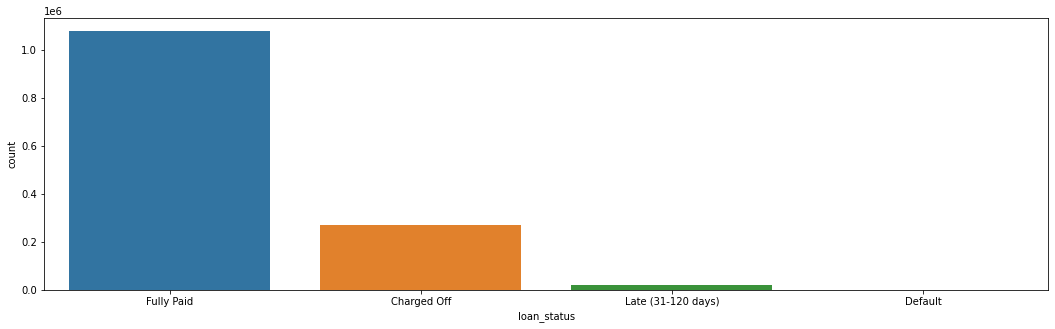

In [35]:
plt.figure(figsize=(18,5))
sns.countplot(data['loan_status'], order=data['loan_status'].value_counts().index)

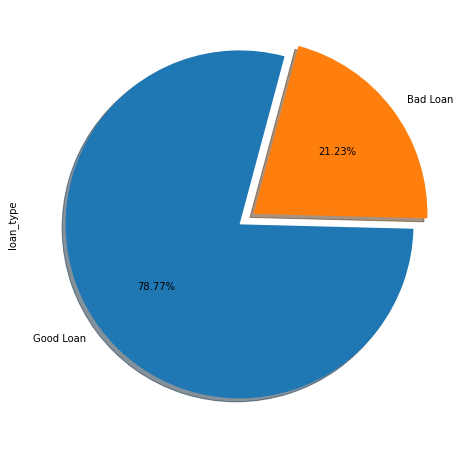

In [36]:
data['loan_type'] = np.nan 
data['loan_type'] = data['loan_status'].apply(loan_type)

plt.figure(figsize=(8,8))
data['loan_type'].value_counts().plot.pie(explode = [0, 0.1], autopct='%1.2f%%', shadow = True, startangle = 75)

Here, we can see a huge imbalance of data between **Good Loans** and **Bad Loans**.

In [37]:
print('Now, the dataset has ', data.shape[0], ' records and ', data.shape[1], ' variables.')

Now, the dataset has  1369566  records and  152  variables.


## **Checking for Missing Values**

Features which have more than 50% of its values missing can be dropped as they add too much noise in the model unless treated otherwise.

In [38]:
missing_value_columns = get_all_missing_value_counts(data)

member_id : 100.00
desc : 90.80
mths_since_last_delinq : 50.39
mths_since_last_record : 82.95
next_pymnt_d : 98.23
mths_since_last_major_derog : 73.69
annual_inc_joint : 97.96
dti_joint : 97.96
verification_status_joint : 97.97
open_acc_6m : 59.29
open_act_il : 59.29
open_il_12m : 59.29
open_il_24m : 59.29
mths_since_rcnt_il : 60.38
total_bal_il : 59.29
il_util : 64.81
open_rv_12m : 59.29
open_rv_24m : 59.29
max_bal_bc : 59.29
all_util : 59.30
inq_fi : 59.29
total_cu_tl : 59.29
inq_last_12m : 59.29
mths_since_recent_bc_dlq : 76.31
mths_since_recent_revol_delinq : 66.59
revol_bal_joint : 98.49
sec_app_fico_range_low : 98.49
sec_app_fico_range_high : 98.49
sec_app_earliest_cr_line : 98.49
sec_app_inq_last_6mths : 98.49
sec_app_mort_acc : 98.49
sec_app_open_acc : 98.49
sec_app_revol_util : 98.52
sec_app_open_act_il : 98.49
sec_app_num_rev_accts : 98.49
sec_app_chargeoff_within_12_mths : 98.49
sec_app_collections_12_mths_ex_med : 98.49
sec_app_mths_since_last_major_derog : 99.45
hardship_t

In [39]:
print('There are a total of ', missing_value_columns, ' features in the dataset which has more than 50% of its values missing.')

There are a total of  58  features in the dataset which has more than 50% of its values missing.


## Variable Insights

In [40]:
temp_df = data[data['loan_type'].isin(['Good Loan', 'Bad Loan'])]

**application_type**

Desc: Indicates whether the loan is an individual application or a joint application with two co-borrowers

In [41]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'application_type'))

Missing value (percentage): 0.0


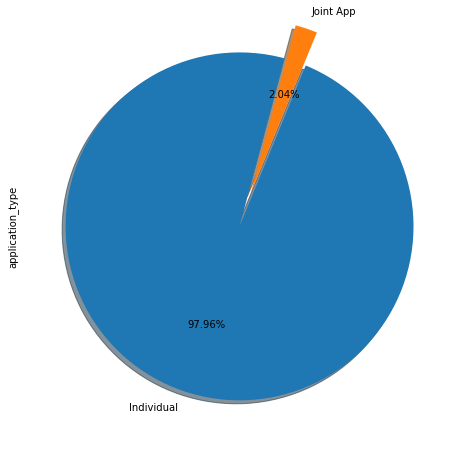

In [42]:
plt.figure(figsize=(8,8))
temp_df['application_type'].value_counts().plot.pie(explode = [0, 0.2], 
                                                    autopct='%1.2f%%', shadow = True, startangle = 75)

Notes on the variable:

- There are no missing values in the variable.
- The variable indicates that about 97.96% of the samples in the data are individual accounts, whereas the rest of 2.04% are joint accounts.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**desc**

Desc: Loan description provided by the borrower

In [43]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'desc'))

Missing value (percentage): 90.8024147795725


Notes on the variable:

- The variable has over 90% values missing.
- It is a free text field.

Hence, we can drop the variable.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**funded_amnt**

Desc: The total amount committed to that loan at that point in time.

**loan_amnt**

Desc: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [44]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'loan_amnt'))

Missing value (percentage): 0.0


In [45]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'funded_amnt'))

Missing value (percentage): 0.0


Text(0.5, 1.0, 'Amount Funded by the Lender')

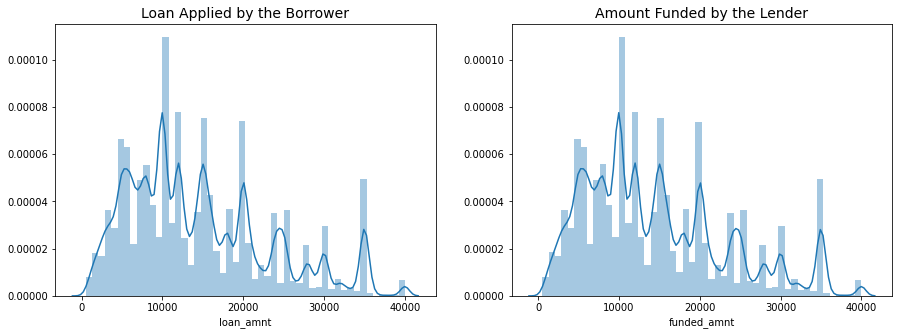

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(temp_df["loan_amnt"], ax=ax[0])
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(temp_df["funded_amnt"], ax=ax[1])
ax[1].set_title("Amount Funded by the Lender", fontsize=14)

Text(0.5, 1.0, 'Loan Applied by the Borrower vs Amount Funded by the Lender')

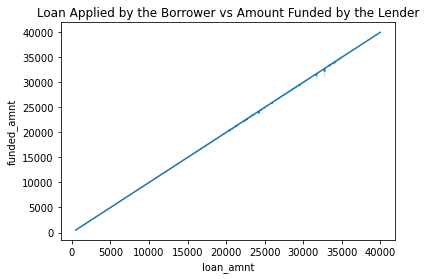

In [47]:
ax = sns.lineplot(x='loan_amnt', y='funded_amnt', data=temp_df)
ax.set_title('Loan Applied by the Borrower vs Amount Funded by the Lender')

Text(0.5, 1.0, 'Loan Amount')

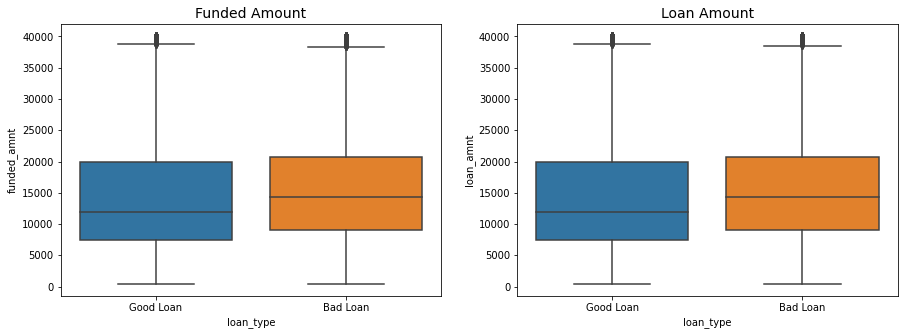

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(x='loan_type', y='funded_amnt', data=temp_df, ax=ax[0])
ax[0].set_title("Funded Amount", fontsize=14)
sns.boxplot(x='loan_type', y='loan_amnt', data=temp_df, ax=ax[1])
ax[1].set_title("Loan Amount", fontsize=14)

Notes on the variables:

- Both the variables **loan_amnt** and **funded_amnt** have no missing values.
- By comparing the above distribution plots and the line plot, we find that the loan applied by the borrower is the same as the loan amount funded by the investor. **Hence, we can drop any one of them.**
- From the boxplot, it is clear that the avg. funded amount and loan amount are more for bad loans. Hence, this can be a good indicator for good/bad loans.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**grade**

Desc: LC assigned loan grade

In [49]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'grade'))

Missing value (percentage): 0.0


Text(0.5, 1.0, 'Distribution of Grade')

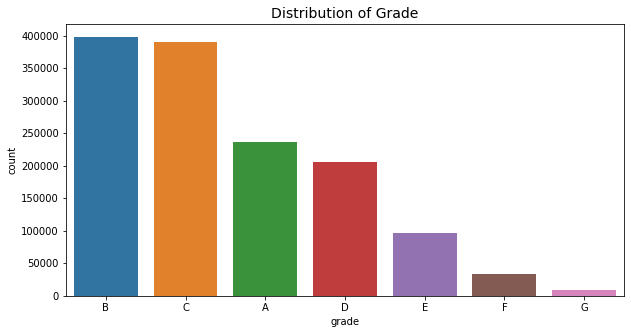

In [50]:
plt.figure(figsize=(10,5))
sns.countplot(data=temp_df, x='grade', order=temp_df['grade'].value_counts().index).set_title("Distribution of Grade", fontsize=14)

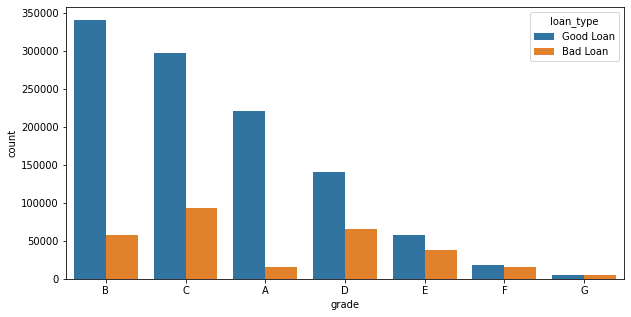

In [51]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='grade', hue='loan_type', data=temp_df, order=temp_df['grade'].value_counts().index)

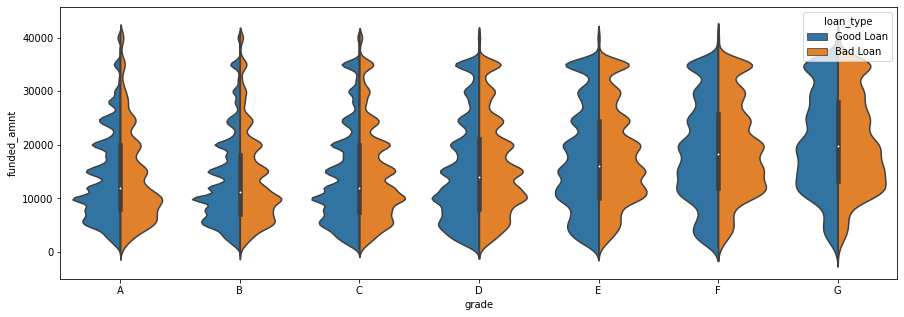

In [52]:
plt.figure(figsize=(15,5))
ax = sns.violinplot(x='grade', y='funded_amnt', hue='loan_type', data=temp_df, split=True, inner='box', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

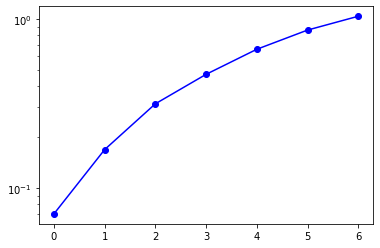

In [53]:
loan_ratio = []
for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # bad loan / good loan
    loan_ratio.append(temp_df[temp_df['grade'] == grade].groupby(['loan_type']).agg(['count']).iloc[0,0] / temp_df[temp_df['grade'] == grade].groupby(['loan_type']).agg(['count']).iloc[1,0])

pd.Series(loan_ratio).plot(kind='line', logy=True, marker='o', color='b')

Notes on the variable:

- Grade has no missing values.
- From graph (1), we find that the most number of loans are in grades B and C, while grades F and G have the least number of loans. This makes a business sense as loans with grades F and G are supposed to be the most risky loans.
- However, in graph (2), we find that with increase in number of loans issued, the number of bad loans is also increasing for grades which are supposed to be less risky. Hence, we need more analysis to determine whether Grade is a good indeicator or not.
- From graph (4), we can prove that as we move towards riskier grades, the ratio of bad loans to total number of loans increases.

**addr_state**

Desc: The state provided by the borrower in the loan application

In [54]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'addr_state'))

Missing value (percentage): 0.0


Text(0.5, 1.0, 'State-wise distribution of Bad Loans')

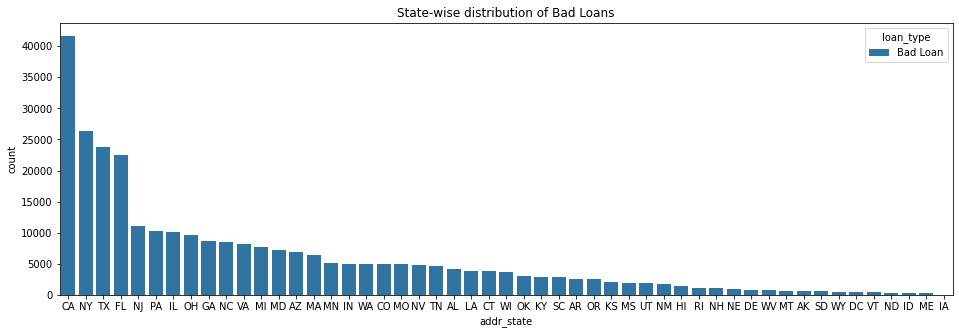

In [55]:
d = data[data['loan_type'].isin(['Bad Loan'])]

plt.figure(figsize=(16,5))
ax = sns.countplot(x='addr_state', hue='loan_type', data=d, order=d['addr_state'].value_counts().index)
ax.set_title('State-wise distribution of Bad Loans', fontsize=12)

Text(0.5, 1.0, 'State-wise distribution of Loans')

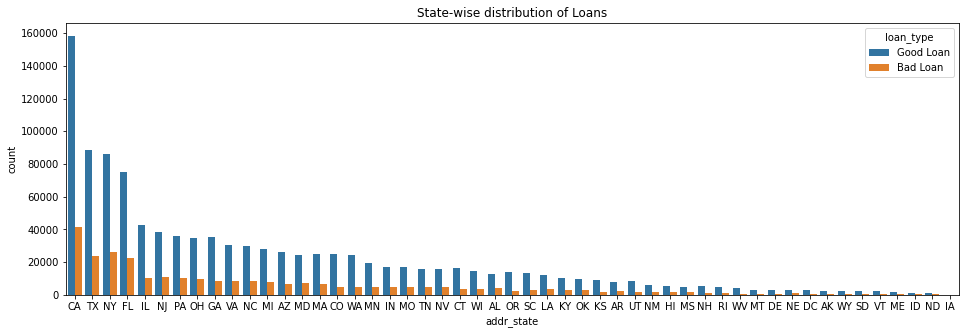

In [56]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='addr_state', hue='loan_type', data=temp_df, order=temp_df['addr_state'].value_counts().index)
ax.set_title('State-wise distribution of Loans', fontsize=12)

Notes on the variable:

- There are no missing values in the variable.
- From the above graph (1), we can say that most of the bad loans occur from the states of CA, NY, TX, FL whereas, the least number of bad loans occur from the states of IA, ME, ID, ND. 
- However, graph (2) shows that this is purely due to the fact that most of loans occur from the former states, while the least number of loans are issued from the latter states.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**annual_inc**

Desc: The self-reported annual income provided by the borrower during registration.

**annual_inc_joint**

Desc: The combined self-reported annual income provided by the co-borrowers during registration

In [57]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'annual_inc'))

Missing value (percentage): 0.0002920633251701634


In [58]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'annual_inc_joint'))

Missing value (percentage): 97.95672497710953


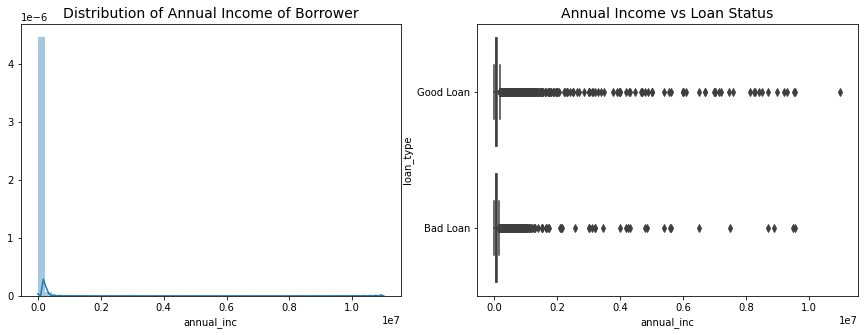

In [59]:
plot_distribution(temp_df.dropna(axis=0, subset=['annual_inc']), 'annual_inc', 'loan_type', 
                  'Distribution of Annual Income of Borrower', 'Annual Income vs Loan Status')

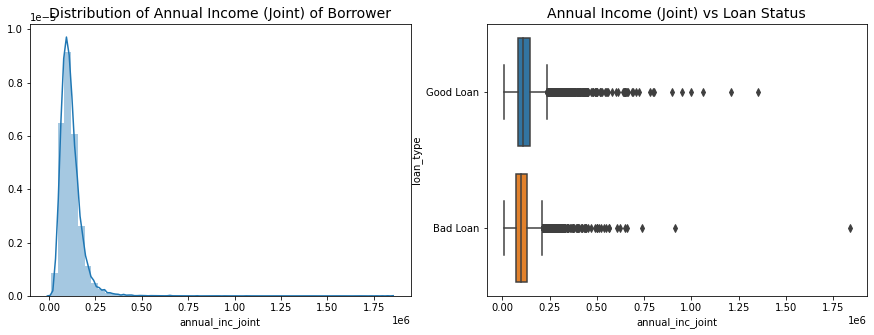

In [60]:
plot_distribution(temp_df.dropna(axis=0, subset=['annual_inc_joint']), 'annual_inc_joint', 'loan_type', 
                  'Distribution of Annual Income (Joint) of Borrower', 'Annual Income (Joint) vs Loan Status')

Notes on the variable:

- **annual_inc** has very less number of missing values whereas **annual_inc_joint** has lot of missing values (due to the fact that there are very less number of samples for joint loan accounts). So, we can combine the two variables into one to avoid lesser noise in the model.
- The data for **annual_inc** seems to be highly skewed. 
- Also there doesn't seem to be an margin that can be used to differentiate between good loan and bad loan.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**emp_length**

Desc: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [61]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'emp_length'))

Missing value (percentage): 5.870545851751577


Text(0.5, 1.0, 'Distribution of Loans across employees of different Employment length')

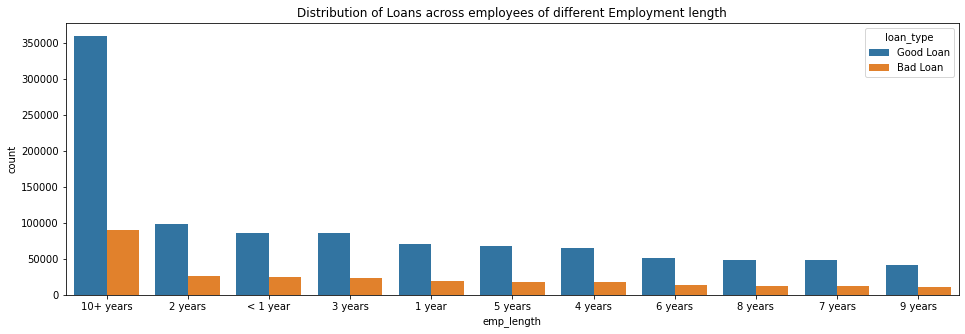

In [62]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='emp_length', hue='loan_type', data=temp_df, order=temp_df['emp_length'].value_counts().index)
ax.set_title('Distribution of Loans across employees of different Employment length', fontsize=12)

In [63]:
temp_df['emp_length'].fillna(value=0,inplace=True)
temp_df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
temp_df['emp_length'] = temp_df['emp_length'].astype(int)

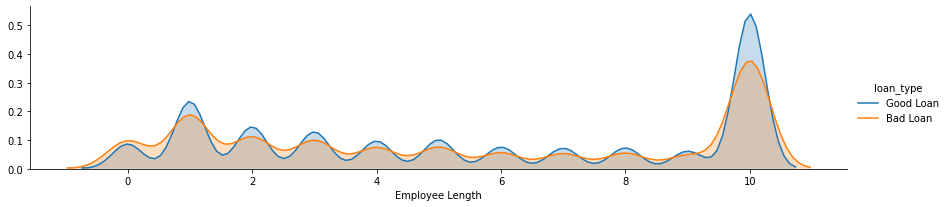

In [64]:
facet = sns.FacetGrid(temp_df, hue = 'loan_type', height=3, aspect=4)
facet.map(sns.kdeplot, 'emp_length', shade=True)
facet.add_legend() 
facet.set_xlabels('Employee Length')

Notes on the variable:

- There is about 5.9% of missing values in the variable.
- The employment length variable is a categorical variable which is then converted to numeric one. 
- From the above graphs (1) and (2), we can say that most of the loans are taken by employees of employment length 10 and above.

**emp_title**

Desc: The job title supplied by the Borrower when applying for the loan.

In [65]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'emp_title'))

Missing value (percentage): 6.423129662973526


In [66]:
print('Total employment titles found: ', temp_df['emp_title'].nunique())

Total employment titles found:  383313


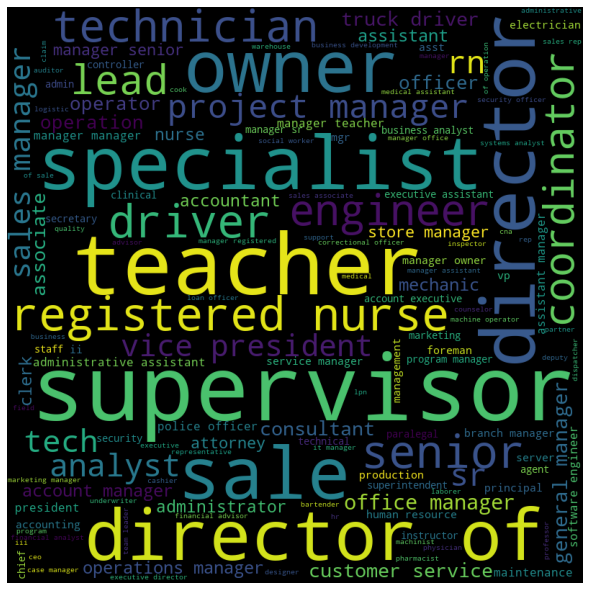

In [67]:
common_words=' ';
for val in temp_df[temp_df['emp_title'].notnull()].emp_title[1:100000]: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()     
    for words in tokens: 
        common_words = common_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, #background_color ='white', 
                      min_font_size = 10).generate(common_words) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Notes on the variable:

- There is about 6.42% of missing values in the variables.
- Also, it is found that there are about 383313 unique employment titles available in the dataset.
- Some of the common employment titles are found in the above word cloud.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

- **home_ownership**

Desc: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

In [68]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'home_ownership'))

Missing value (percentage): 0.0


Text(0.5, 1.0, 'Distribution of Home Ownership Data')

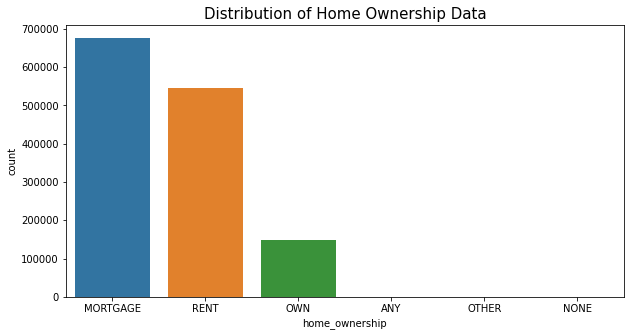

In [69]:
plt.figure(figsize=(10,5))
sns.countplot(data=temp_df, x='home_ownership', order=temp_df['home_ownership'].value_counts().index).set_title("Distribution of Home Ownership Data", fontsize=15)

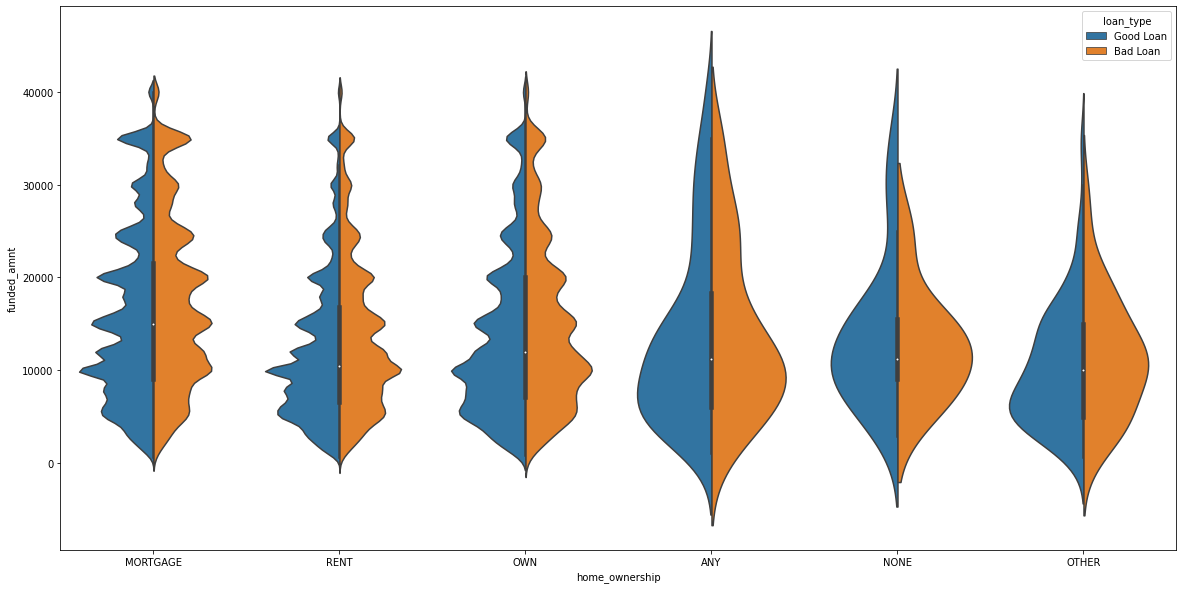

In [70]:
plt.figure(figsize=(20,10))
ax = sns.violinplot(x='home_ownership', y='funded_amnt', hue='loan_type', data=temp_df, split=True, inner='box')

In [71]:
for home_ownership in ['MORTGAGE', 'RENT', 'OWN', 'ANY', 'NONE', 'OTHER']:
    loan_ratio = temp_df[temp_df['home_ownership'] == home_ownership].groupby(['loan_type']).agg(['count']).iloc[0,0] / temp_df[temp_df['home_ownership'] == home_ownership].groupby(['loan_type']).agg(['count']).iloc[1,0]
    print(home_ownership, ' : ', loan_ratio)

MORTGAGE  :  0.22502518316677417
RENT  :  0.3255766453175379
OWN  :  0.2832780219971157
ANY  :  0.3217391304347826
NONE  :  0.17777777777777778
OTHER  :  0.2638888888888889


Notes on the variable:

- We find that there is no missing values in the dataset for this variable.
- From graph (1), we find that people with house mortgage tend to take more loans.
- Also, we find there is no clear difference in the ratio of good and bad loans for any categories of house ownership.
- However, from the violin plot we find that people with house mortgage tend to take higher loan amounts and people with higher loan amounts tend to default.
- Thus, we can consider House Ownership (home_ownership) as an indicator for bad loans.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**zip_code**

Desc: The first 3 numbers of the zip code provided by the borrower in the loan application.

In [72]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'zip_code'))

Missing value (percentage): 7.301583129254084e-05


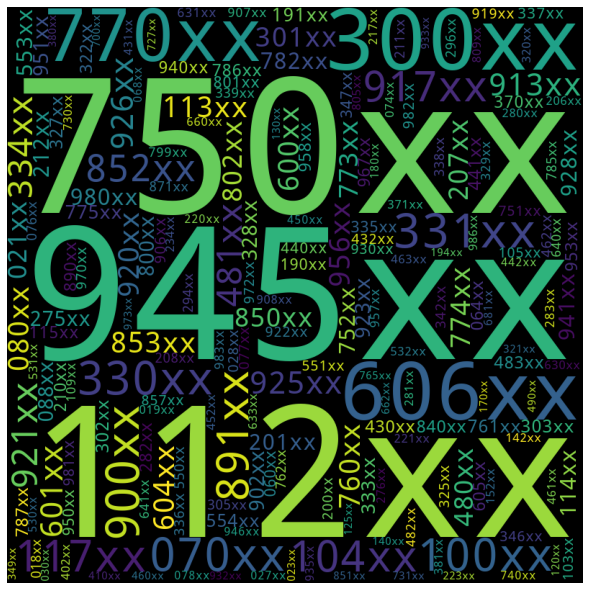

In [73]:
common_words=' ';
for val in temp_df[temp_df['zip_code'].notnull()].zip_code[1:100000]: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()     
    for words in tokens: 
        common_words = common_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, #background_color ='white', 
                      min_font_size = 10).generate(common_words) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Notes on the variable:

- There is very little missing values in the variables.
- Some of the common zip codes are found in the above word cloud.
- We find that the data is masked and also in the presence of **addr_state** is redundant.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**acc_now_delinq**

Desc: The number of accounts on which the borrower is now delinquent.

In [74]:
print('Missing value (percentage):', get_missing_value_count(temp_df,'acc_now_delinq'))

Missing value (percentage): 0.0021174591074836846


In [75]:
temp_df['acc_now_delinq'].unique()

array([ 0.,  1.,  2.,  4.,  3.,  5.,  6., 14., nan])

In [76]:
temp_df['acc_now_delinq'].value_counts()

0.0     1363113
1.0        6057
2.0         310
3.0          42
4.0          10
5.0           3
14.0          1
6.0           1
Name: acc_now_delinq, dtype: int64

In [77]:
temp_df['acc_now_delinq'] = temp_df['acc_now_delinq'].fillna(0)

In [78]:
temp_df['acc_now_delinq'].value_counts()

0.0     1363142
1.0        6057
2.0         310
3.0          42
4.0          10
5.0           3
14.0          1
6.0           1
Name: acc_now_delinq, dtype: int64

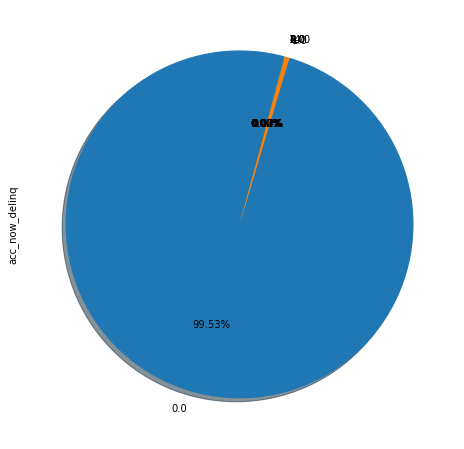

In [79]:
plt.figure(figsize=(8,8))
data['acc_now_delinq'].value_counts().plot.pie(autopct='%1.2f%%', shadow = True, startangle = 75)

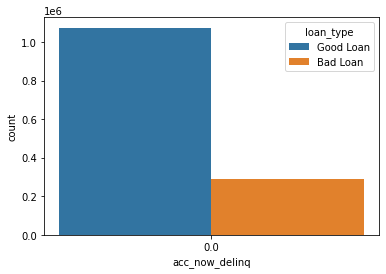

In [80]:
sns.countplot(x='acc_now_delinq', hue='loan_type', data=temp_df[temp_df['acc_now_delinq']==0])

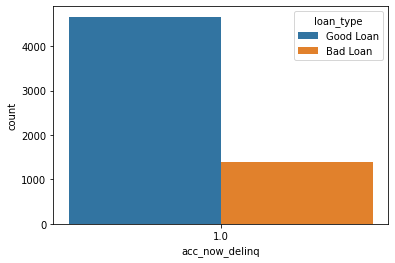

In [81]:
sns.countplot(x='acc_now_delinq', hue='loan_type', data=temp_df[temp_df['acc_now_delinq']==1])

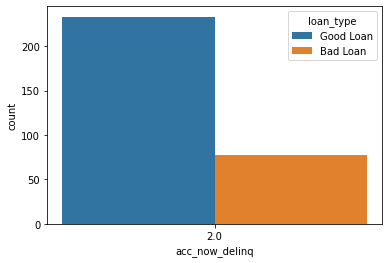

In [82]:
sns.countplot(x='acc_now_delinq', hue='loan_type', data=temp_df[temp_df['acc_now_delinq']==2])

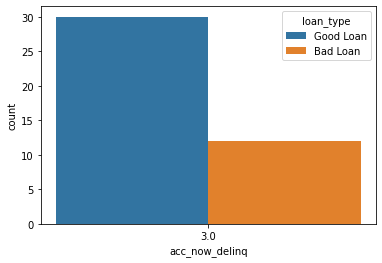

In [83]:
sns.countplot(x='acc_now_delinq', hue='loan_type', data=temp_df[temp_df['acc_now_delinq']==3])

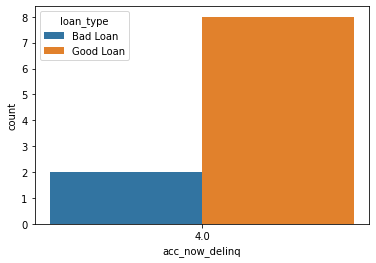

In [84]:
sns.countplot(x='acc_now_delinq', hue='loan_type', data=temp_df[temp_df['acc_now_delinq']==4])

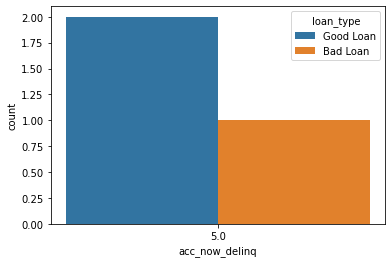

In [85]:
sns.countplot(x='acc_now_delinq', hue='loan_type', data=temp_df[temp_df['acc_now_delinq']==5])

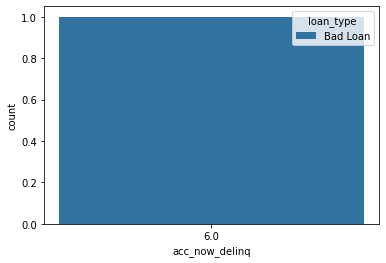

In [86]:
sns.countplot(x='acc_now_delinq', hue='loan_type', data=temp_df[temp_df['acc_now_delinq']==6])

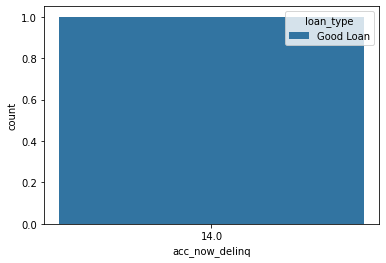

In [87]:
sns.countplot(x='acc_now_delinq', hue='loan_type', data=temp_df[temp_df['acc_now_delinq']==14])

Notes on the variable:
- The variable has very insignificant number of missing values (0.002%). 
- The values can be classified as : 0,1,2,3,4,5,6,14.
- We can consider that if a certain sample has missing value at 'acc_now_delinq', then the value will be 0.
- After imputing the missing values, there is not much significant change in the distribution of the variable. 
- We find that about 99.53% of the values are '0'. The remaining values are distributed into the remaining classes most of which is again '1'.
- By checking the distribution of each class over good/bad loan types, we find that borrowers having multiple delinquent accounts have more good loans than bad loans. This maybe due to the imbalance of loan_status distribution in the dataset.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**acc_open_past_24mths**

Desc: Number of trades opened in past 24 months.

In [88]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'acc_open_past_24mths'))

The number of missing values (%age):  3.6529820395658184


In [89]:
temp_df['acc_open_past_24mths'].nunique()

55

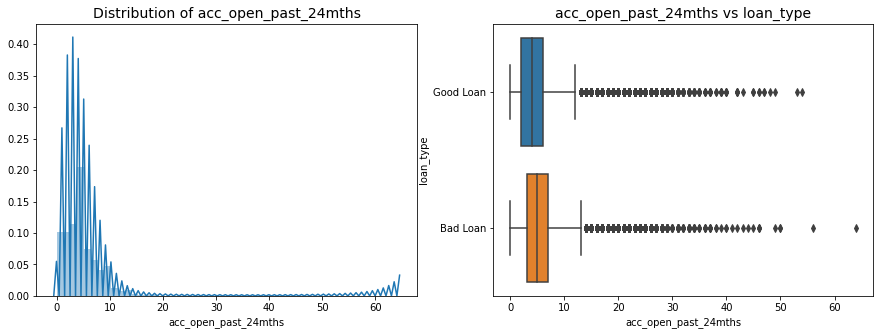

In [90]:
plot_distribution(temp_df.dropna(axis=0, subset=['acc_open_past_24mths']), 'acc_open_past_24mths', 'loan_type', 
                  'Distribution of acc_open_past_24mths', 'acc_open_past_24mths vs loan_type')

In [91]:
temp_df['acc_open_past_24mths'] = impute_by_mice(temp_df, 'acc_open_past_24mths', 'float')

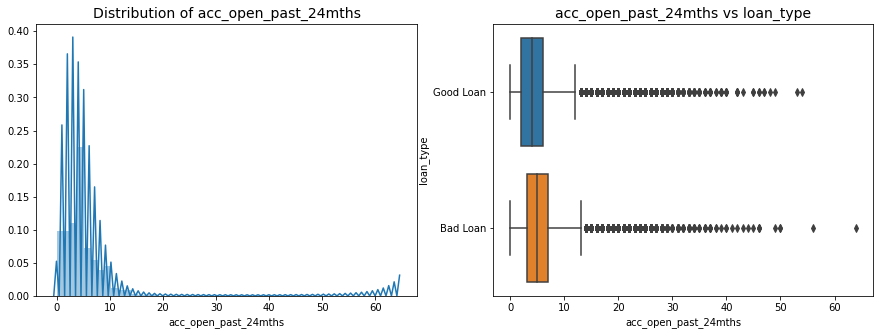

In [92]:
plot_distribution(temp_df.dropna(axis=0, subset=['acc_open_past_24mths']), 'acc_open_past_24mths', 'loan_type', 
                  'Distribution of acc_open_past_24mths', 'acc_open_past_24mths vs loan_type')

Notes on the variable:
- The variable has approx 3.65% of missing data.
- The data is highly skewed.
- MICE imputation is performed on the variable. 
- From the above distributions, we find that because of the lesser number of missing values in the variable, the imputation doesn't change the distribution much.
- From the box plot, we find that the there is no clear difference between the avg for good and bad loans. 

Thus, we can say that **acc_open_past_24mths** is not a very good predictor for **loan_status**. 

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**open_il_24m**

Desc: Number of installment accounts opened in past 24 months

**open_rv_24m**

Desc: Number of revolving trades opened in past 24 months

In [93]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'open_il_24m'))

The number of missing values (%age):  59.29228675361392


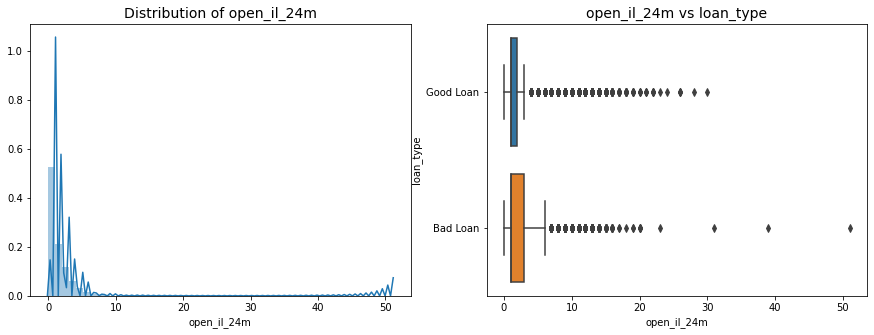

In [94]:
plot_distribution(temp_df.dropna(axis=0, subset=['open_il_24m']), 'open_il_24m', 'loan_type', 
                  'Distribution of open_il_24m', 'open_il_24m vs loan_type')

In [95]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'open_rv_24m'))

The number of missing values (%age):  59.29228675361392


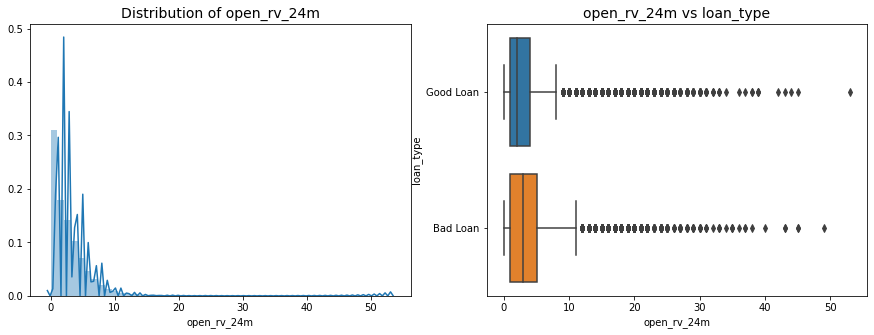

In [96]:
plot_distribution(temp_df.dropna(axis=0, subset=['open_rv_24m']), 'open_rv_24m', 'loan_type', 
                  'Distribution of open_rv_24m', 'open_rv_24m vs loan_type')

Text(0.5, 1.0, 'acc_open_past_24mths vs open_il_24m')

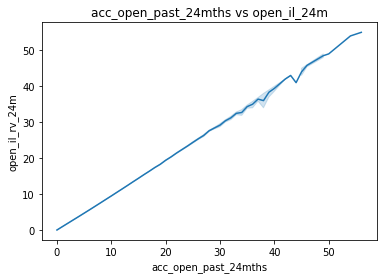

In [97]:
temp_df['open_il_rv_24m'] = temp_df['open_il_24m'] + temp_df['open_rv_24m']
ax = sns.lineplot(x='acc_open_past_24mths', y='open_il_rv_24m', data=temp_df)
ax.set_title('acc_open_past_24mths vs open_il_24m')

Notes on the variable:

- Both variables have approx 59.29% of missing data.
- The data is highly skewed.
- Also, from the line plot, we find that there is somewhat a linear relation between **acc_open_past_24mths** and the summation of **open_il_24m** with **open_rv_24m**. This concludes that **open_il_24m** and **open_rv_24m** together forms **acc_open_past_24mths**. The disturbance in the plot towards the end is probably due to the high number of missing values in **open_il_24m** and **open_rv_24m**.

We can thus conclude to drop **open_il_24m** and **open_rv_24m** as they add too much noise to the model and use **acc_open_past_24mths** instead.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**all_util**

Desc: Balance to credit limit on all trades

In [98]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'all_util'))

The number of missing values (%age):  59.296375640166296


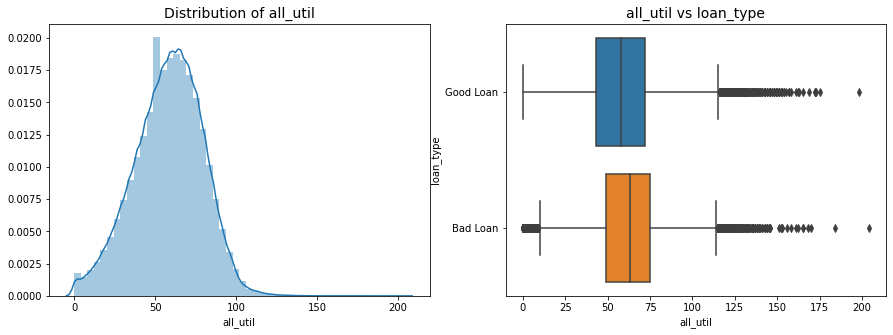

In [99]:
plot_distribution(temp_df.dropna(axis=0, subset=['all_util']), 'all_util', 'loan_type', 
                  'Distribution of all_util', 'all_util vs loan_type')

Notes on the variable:
- The variable has approx 59.29% of missing data.
- Although the data seems to be normal but due to high number of missing values, imputing such a variable will disturb the distribution completely.

Hence, we can conclude to drop the variable **all_util**.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**avg_cur_bal**

Desc: avg_cur_bal - Average current balance of all accounts

**tot_cur_bal**

Desc: Total current balance of all accounts

In [100]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'avg_cur_bal'))

The number of missing values (%age):  5.132939924034329


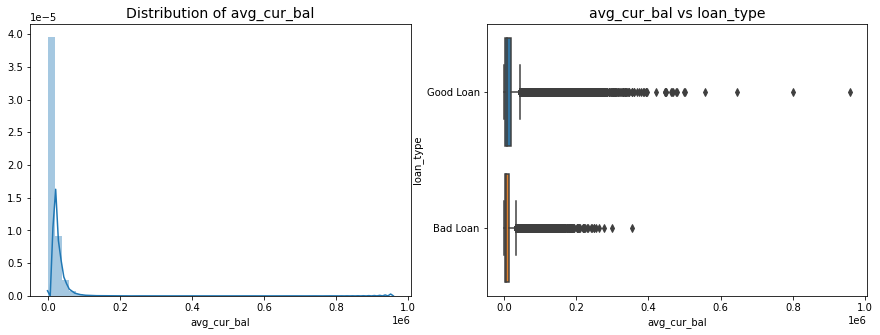

In [101]:
plot_distribution(temp_df.dropna(axis=0, subset=['avg_cur_bal']), 'avg_cur_bal', 'loan_type', 
                  'Distribution of avg_cur_bal', 'avg_cur_bal vs loan_type')

In [102]:
temp_df['avg_cur_bal'] = impute_by_mice(temp_df, 'avg_cur_bal', 'float')

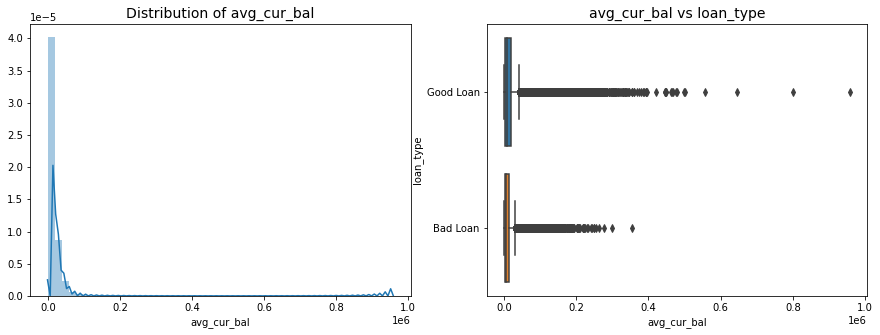

In [103]:
plot_distribution(temp_df, 'avg_cur_bal', 'loan_type', 
                  'Distribution of avg_cur_bal', 'avg_cur_bal vs loan_type')

In [104]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'tot_cur_bal'))

The number of missing values (%age):  5.131260559914601


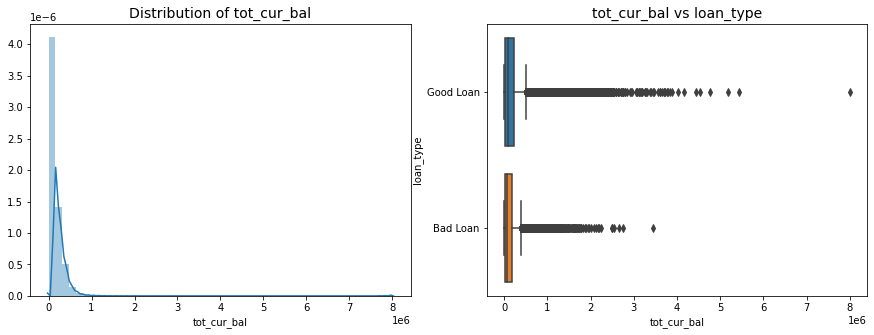

In [105]:
plot_distribution(temp_df.dropna(axis=0, subset=['tot_cur_bal']), 'tot_cur_bal', 'loan_type', 
                  'Distribution of tot_cur_bal', 'tot_cur_bal vs loan_type')

In [106]:
temp_df['tot_cur_bal'] = impute_by_mice(temp_df, 'tot_cur_bal', 'float')

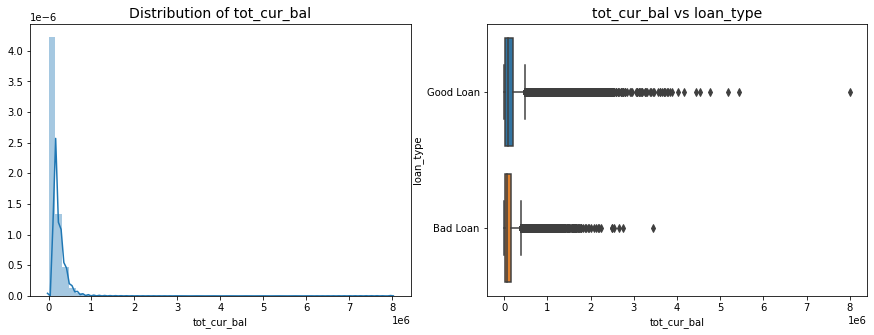

In [107]:
plot_distribution(temp_df.dropna(axis=0, subset=['tot_cur_bal']), 'tot_cur_bal', 'loan_type', 
                  'Distribution of tot_cur_bal', 'tot_cur_bal vs loan_type')

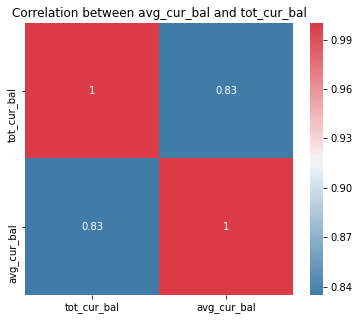

In [108]:
features = ['tot_cur_bal', 'avg_cur_bal']
get_heat_map(temp_df, features, 6, 5, 'Correlation between avg_cur_bal and tot_cur_bal')

Notes on the variables:

- Both variables have approx 5.13% of missing data.
- The data seems to be highly skewed. Also, from the box plot, we find that it is difficult to find the difference of averages to indicate a good or bad loan.
- MICE imputation is performed on the variable. After imputation the distribution remains almost same due to lees number of missing values.
- From the heat map, we find that both variables **tot_cur_bal** and **avg_cur_bal** are highly correlated.
- From the description, we find that both varaibles are related as:

From this we can conclude to drop **tot_cur_bal** and use **avg_cur_bal** instead.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**tot_hi_cred_lim**

Desc: Total high credit/credit limit

**total_bc_limit**

Desc: Total bankcard high credit/credit limit

**total_rev_hi_lim**

Desc: Total revolving high credit/credit limit

**total_il_high_credit_limit**

Desc: Total installment high credit/credit limit

In [109]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'total_rev_hi_lim'))

The number of missing values (%age):  5.131260559914601


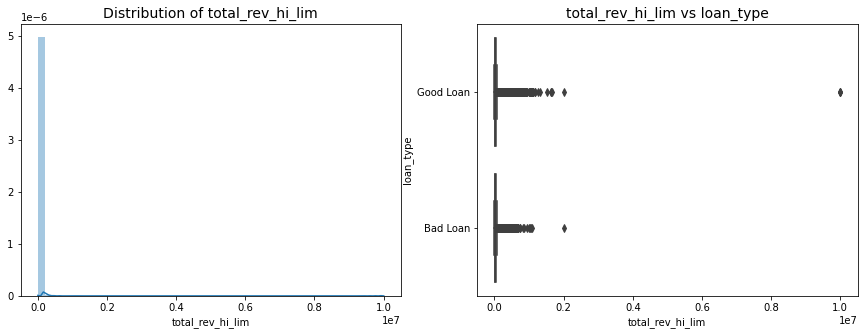

In [110]:
plot_distribution(temp_df.dropna(axis=0, subset=['total_rev_hi_lim']), 'total_rev_hi_lim', 'loan_type', 
                  'Distribution of total_rev_hi_lim', 'total_rev_hi_lim vs loan_type')

In [111]:
temp_df['total_rev_hi_lim'] = impute_by_mice(temp_df, 'total_rev_hi_lim', 'float')

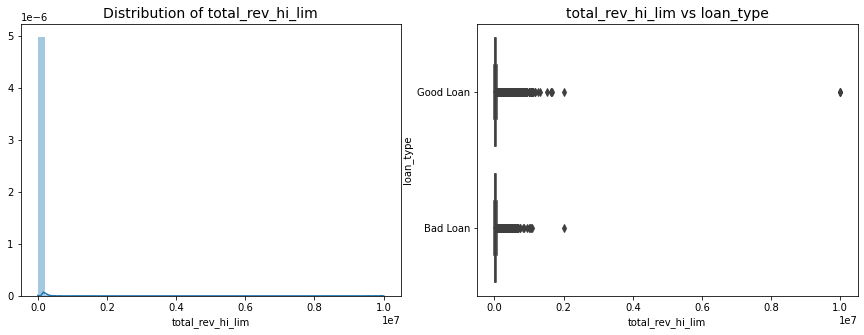

In [112]:
plot_distribution(temp_df.dropna(axis=0, subset=['total_rev_hi_lim']), 'total_rev_hi_lim', 'loan_type', 
                  'Distribution of total_rev_hi_lim', 'total_rev_hi_lim vs loan_type')

In [113]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'total_bc_limit'))

The number of missing values (%age):  3.6529820395658184


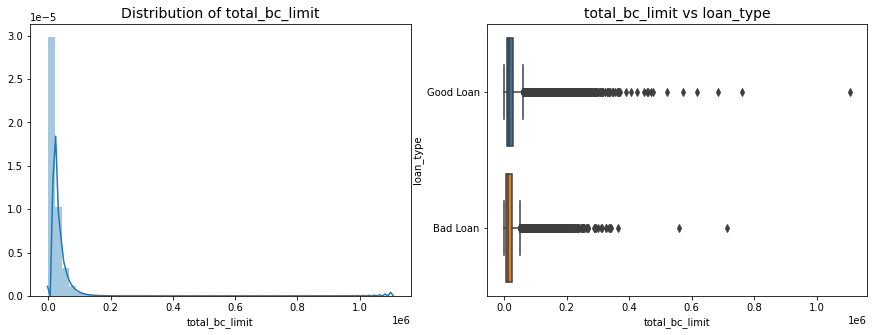

In [114]:
plot_distribution(temp_df.dropna(axis=0, subset=['total_bc_limit']), 'total_bc_limit', 'loan_type', 
                  'Distribution of total_bc_limit', 'total_bc_limit vs loan_type')

In [115]:
temp_df['total_bc_limit'] = impute_by_mice(temp_df, 'total_bc_limit', 'float')

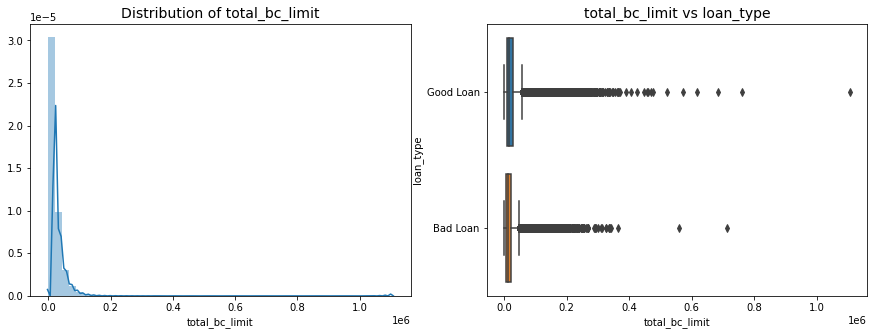

In [116]:
plot_distribution(temp_df.dropna(axis=0, subset=['total_bc_limit']), 'total_bc_limit', 'loan_type', 
                  'Distribution of total_bc_limit', 'total_bc_limit vs loan_type')

In [117]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'tot_hi_cred_lim'))

The number of missing values (%age):  5.131260559914601


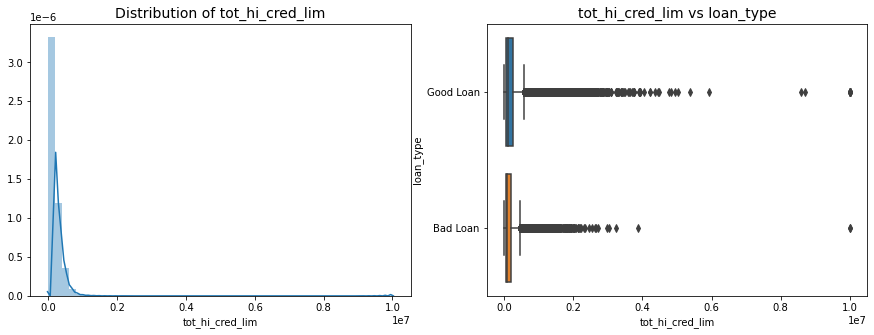

In [118]:
plot_distribution(temp_df.dropna(axis=0, subset=['tot_hi_cred_lim']), 'tot_hi_cred_lim', 'loan_type', 
                  'Distribution of tot_hi_cred_lim', 'tot_hi_cred_lim vs loan_type')

In [119]:
temp_df['tot_hi_cred_lim'] = impute_by_mice(temp_df, 'tot_hi_cred_lim', 'float')

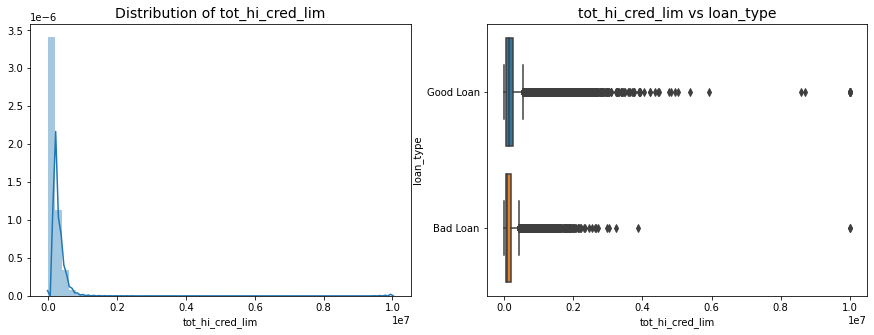

In [120]:
plot_distribution(temp_df.dropna(axis=0, subset=['tot_hi_cred_lim']), 'tot_hi_cred_lim', 'loan_type', 
                  'Distribution of tot_hi_cred_lim', 'tot_hi_cred_lim vs loan_type')

In [121]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'total_il_high_credit_limit'))

The number of missing values (%age):  5.131260559914601


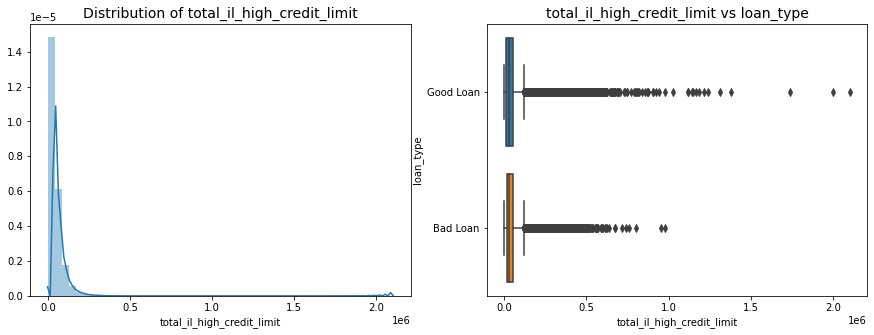

In [122]:
plot_distribution(temp_df.dropna(axis=0, subset=['total_il_high_credit_limit']), 'total_il_high_credit_limit', 'loan_type', 
                  'Distribution of total_il_high_credit_limit', 'total_il_high_credit_limit vs loan_type')

In [123]:
temp_df['total_il_high_credit_limit'] = impute_by_mice(temp_df, 'total_il_high_credit_limit', 'float')

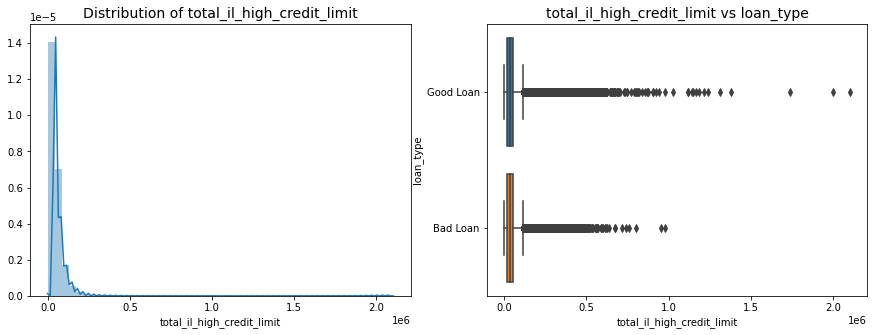

In [124]:
plot_distribution(temp_df.dropna(axis=0, subset=['total_il_high_credit_limit']), 'total_il_high_credit_limit', 'loan_type', 
                  'Distribution of total_il_high_credit_limit', 'total_il_high_credit_limit vs loan_type')

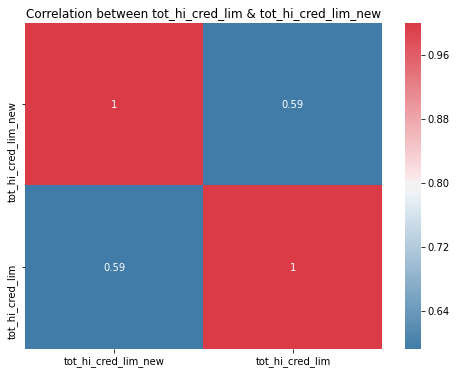

In [125]:
temp_df['tot_hi_cred_lim_new'] = temp_df['total_il_high_credit_limit'] + temp_df['total_bc_limit'] + temp_df['total_rev_hi_lim']

features = ['tot_hi_cred_lim_new', 'tot_hi_cred_lim']
get_heat_map(temp_df, features, 8, 6, 'Correlation between tot_hi_cred_lim & tot_hi_cred_lim_new')

Text(0.5, 1.0, 'tot_hi_cred_lim vs (total_il_high_credit_limit + total_bc_limit + total_rev_hi_lim)')

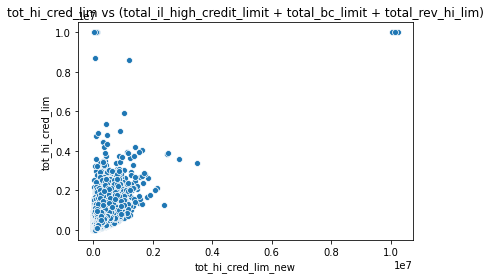

In [126]:
ax = sns.scatterplot(x='tot_hi_cred_lim_new', y='tot_hi_cred_lim', data=temp_df)
ax.set_title('tot_hi_cred_lim vs (total_il_high_credit_limit + total_bc_limit + total_rev_hi_lim)')

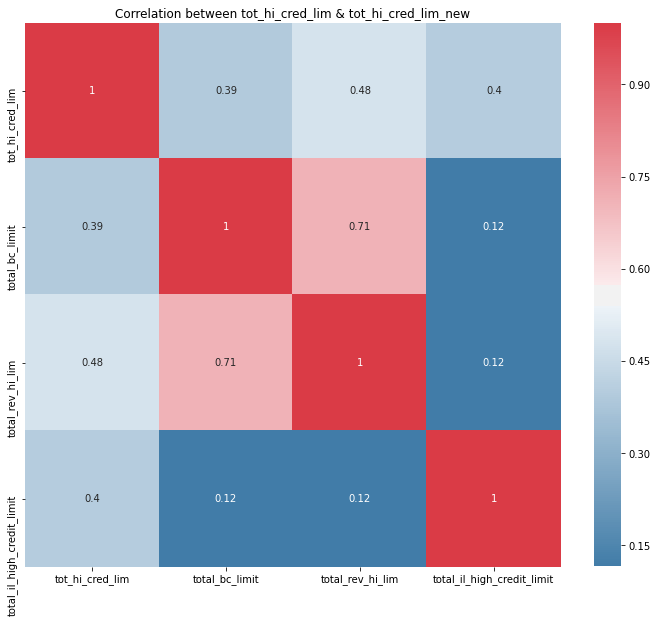

In [127]:
features = ['tot_hi_cred_lim', 'total_bc_limit', 'total_rev_hi_lim', 'total_il_high_credit_limit']
get_heat_map(temp_df, features, 12, 10, 'Correlation between tot_hi_cred_lim & tot_hi_cred_lim_new')

Note on the variables:

- We find that the variables **total_il_high_credit_limit** (5.13%), **total_rev_hi_lim** (5.13%), **total_bc_limit** (3.65%) and **tot_hi_cred_lim** (5.13%)  have less number of missing values.
- MICE imputation is performed on the variables after which there is not much change in the distribution of the variables.
- From the distributions and box plots, we find the variables to be highly skewed.
- From the descriptions of the variables, it seems the varables are related as: **tot_hi_cred_lim** = **total_rev_hi_lim** + **total_bc_limit** + **total_il_high_credit_limit**. However, from the the heat map, we are not able to prove the same.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

**total_bal_il**

Desc: Total current balance of all installment accounts

**il_util**

Desc: Ratio of total current balance to high credit/credit limit on all install accounts.

In [128]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'total_bal_il'))

The number of missing values (%age):  59.29228675361392


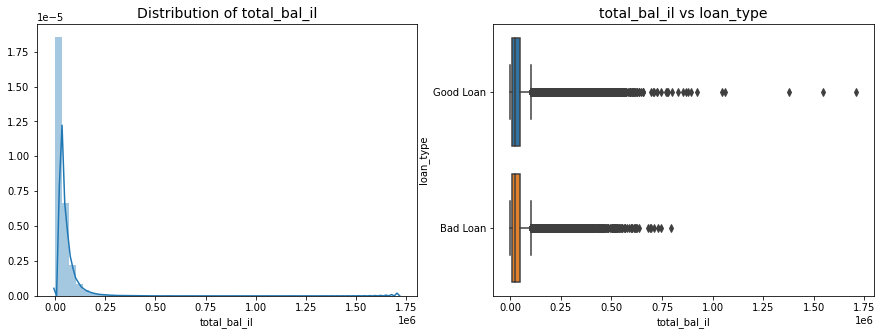

In [129]:
plot_distribution(temp_df.dropna(axis=0, subset=['total_bal_il']), 'total_bal_il', 'loan_type', 
                  'Distribution of total_bal_il', 'total_bal_il vs loan_type')

In [130]:
print('The number of missing values (%age): ', get_missing_value_count(temp_df,'il_util'))

The number of missing values (%age):  64.80731852280212


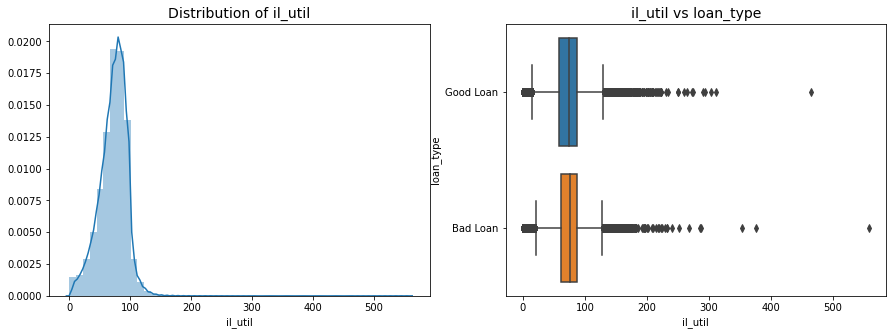

In [131]:
plot_distribution(temp_df.dropna(axis=0, subset=['il_util']), 'il_util', 'loan_type', 
                  'Distribution of il_util', 'il_util vs loan_type')

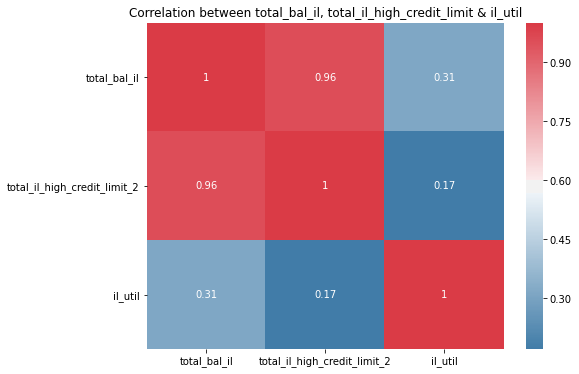

In [132]:
temp_df['total_il_high_credit_limit_2'] = data[data['loan_type'].isin(['Good Loan', 'Bad Loan'])]['total_il_high_credit_limit']

features = ['total_bal_il', 'total_il_high_credit_limit_2', 'il_util']
get_heat_map(temp_df, features, 8, 6, 'Correlation between total_bal_il, total_il_high_credit_limit & il_util')

Notes on the variables:

- From the definition, we find that all 3 variables are related as : 
**total_bal_il / total_il_high_credit_limit = il_util**
- However, **total_bal_il** (59.29%) and **il_util** (64.8%) have very high number of missing values, whereas **total_il_high_credit_limit** has just 5.13% of missing values.
- Fron the heat map, we find that there is high correlation between **total_il_high_credit_limit** and **total_bal_il**.
- MICE imputation is done on **total_il_high_credit_limit**.
- After imputation we find that although the distribution of **total_il_high_credit_limit** does not change much, but it increases the central tendency of the variable.
- From the box plot of **total_il_high_credit_limit**, we find that there is no difference between the means for good and bad loans.

From this, we can conclude to drop **total_bal_il** and **il_util** due to high number of missing values and use **total_il_high_credit_limit** instead.

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**